In [2]:
pip install --upgrade scikit-learn

  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
Note: you may need to restart the kernel to use updated packages.


Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\muzzamil\\anaconda\\lib\\site-packages\\~klearn\\ensemble\\_gradient_boosting.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


# Import libraries

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, recall_score, precision_score, classification_report
from sklearn.metrics import average_precision_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier, RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

# Define functions

In [3]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# -----------------------------------------------------------------------------------------------
def outlier_detect_normal(df, col):
    m = df[col].mean()
    s = df[col].std()
    return df[((df[col]-m)/s).abs()>3]

# -----------------------------------------------------------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# -----------------------------------------------------------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# -----------------------------------------------------------------------------------------------
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)
    print('outlier replace with upper bound - {}' .format(col)) 
    
# -----------------------------------------------------------------------------------------------
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)
    print('outlier replace with lower bound - {}' .format(col)) 

# -----------------------------------------------------------------------------------------------
def preprocess(df, col):
    print("************************************************ {} ************************************************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.subplot(2,1,2)
    df[col].plot(kind='density', subplots=True, sharex=False)
    plt.show()
    

# -----------------------------------------------------------------------------------------------
def Cls_model_RndSrch_Tune(model, Data, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='accuracy', cv = 5, n_jobs=-1)
    clf.fit(X, y)
    
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    
    return (clf.best_score_)

# -----------------------------------------------------------------------------------------------
def Cls_model_GrdSrch_Tune(model, Data, X, y, params):
    
    clf = GridSearchCV(model, params, scoring ='accuracy', cv = 5, n_jobs=-1)
    clf.fit(X, y)
    
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    
    return (clf.best_score_)


# Data Understanding

In [4]:
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.shape

(918, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [8]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

1    508
0    410
Name: HeartDisease, dtype: int64

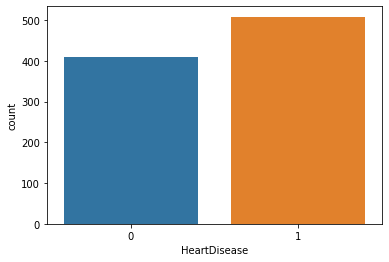

In [9]:
sns.countplot(x = "HeartDisease", data = df)
df.loc[:, 'HeartDisease'].value_counts()

In [10]:
categorical_feature = df.dtypes==object
final_categorical_feature = df.columns[categorical_feature].tolist()
# -----------------------------------------------------------------------------
final_numeric_feature = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

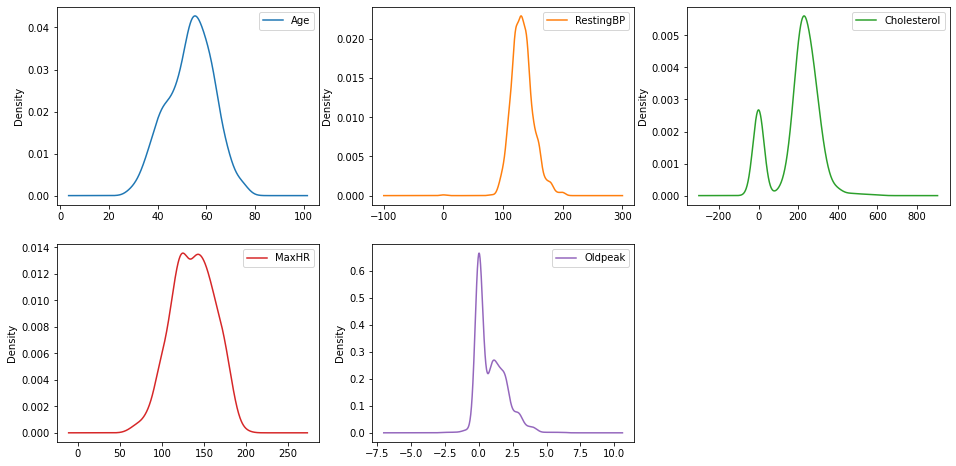

In [11]:
df[final_numeric_feature].plot(kind='density', subplots=True, layout=(2,3), sharex=False, figsize= (16,8))
plt.show()

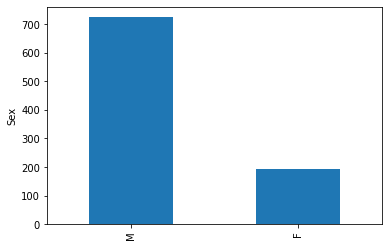

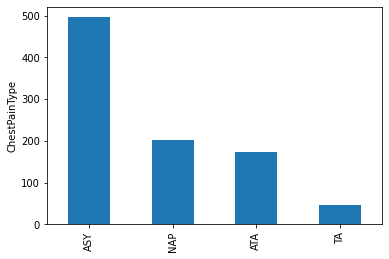

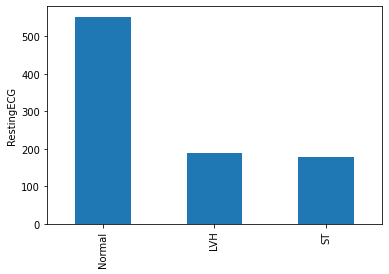

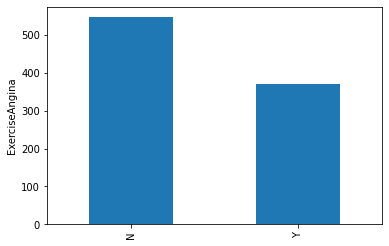

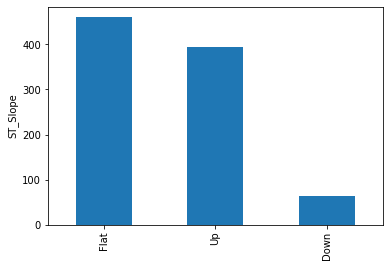

In [12]:
for i in range(len(final_categorical_feature)):
    df[final_categorical_feature[i]].value_counts().plot(kind='bar')
    plt.xticks(rotation='vertical')
    plt.ylabel(final_categorical_feature[i])
    plt.show()

# Preprocessing

### Manage Outlier

In [13]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

In [14]:
for i in range(len(final_numeric_feature)):
    print("IQR => {}: {}".format(final_numeric_feature[i],(outlier_detect(df[final_numeric_feature],final_numeric_feature[i]).shape[0])))
    print("Z_Score => {}: {}".format(final_numeric_feature[i],(outlier_detect_normal(df[final_numeric_feature],final_numeric_feature[i]).shape[0])))
    print("********************************")

IQR => Age: 0
Z_Score => Age: 0
********************************
IQR => RestingBP: 28
Z_Score => RestingBP: 8
********************************
IQR => Cholesterol: 183
Z_Score => Cholesterol: 3
********************************
IQR => MaxHR: 2
Z_Score => MaxHR: 1
********************************
IQR => Oldpeak: 16
Z_Score => Oldpeak: 7
********************************


************************************************ Age ************************************************

lower outlier: 0 ****** upper outlier: 0



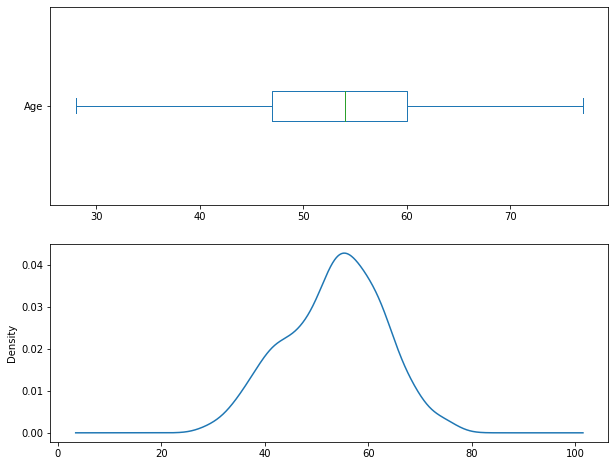

************************************************ RestingBP ************************************************

lower outlier: 2 ****** upper outlier: 26



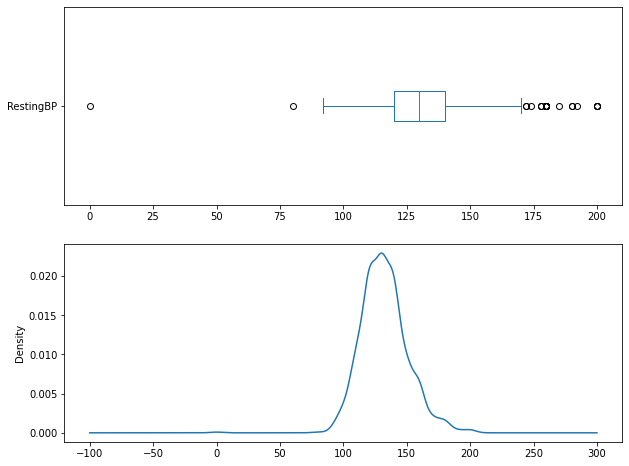

************************************************ Cholesterol ************************************************

lower outlier: 172 ****** upper outlier: 11



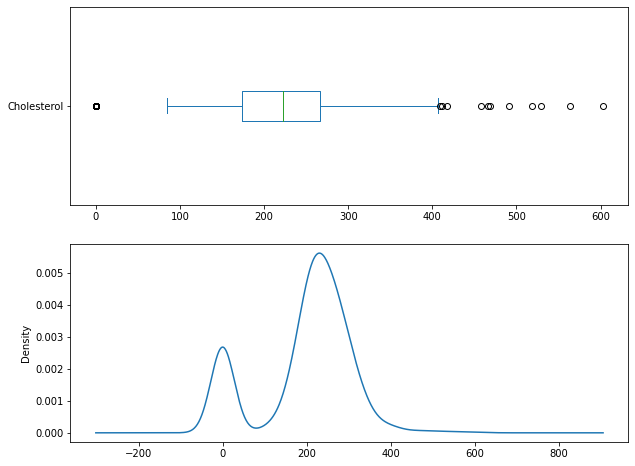

************************************************ MaxHR ************************************************

lower outlier: 2 ****** upper outlier: 0



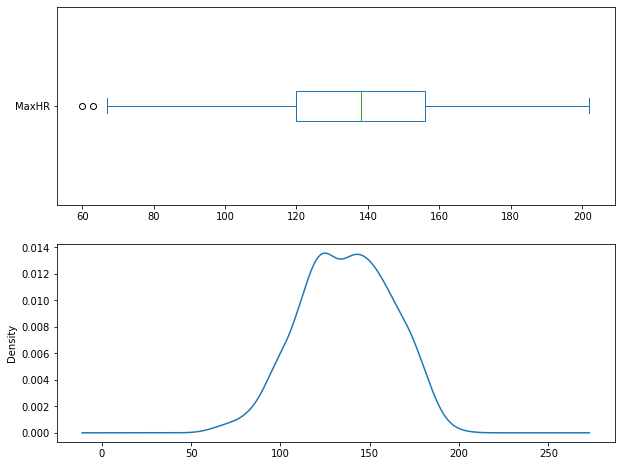

************************************************ Oldpeak ************************************************

lower outlier: 1 ****** upper outlier: 15



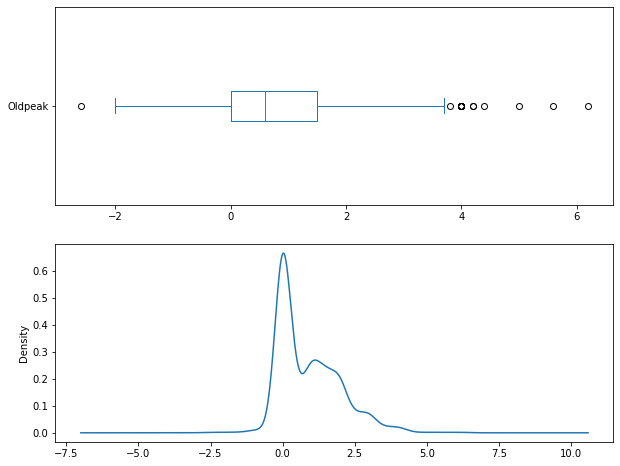

In [15]:
for i in range(len(final_numeric_feature)):
    preprocess(df[final_numeric_feature], final_numeric_feature[i])

In [16]:
outlier = []
for i in range(len(final_numeric_feature)):
    if outlier_detect(df[final_numeric_feature],final_numeric_feature[i]).shape[0] !=0:
        outlier.append(final_numeric_feature[i])

outlier

['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [17]:
for i in range(len(outlier)):
    replace_upper(df, outlier[i]) 
    
print("\n***************************************************************\n")
for i in range(len(outlier)):
    replace_lower(df, outlier[i])

outlier replace with upper bound - RestingBP
outlier replace with upper bound - Cholesterol
outlier replace with upper bound - MaxHR
outlier replace with upper bound - Oldpeak

***************************************************************

outlier replace with lower bound - RestingBP
outlier replace with lower bound - Cholesterol
outlier replace with lower bound - MaxHR
outlier replace with lower bound - Oldpeak


In [18]:
for i in range(len(final_numeric_feature)):
    print("IQR => {}: {}".format(final_numeric_feature[i],(outlier_detect(df,final_numeric_feature[i]).shape[0])))
    print("Z_Score => {}: {}".format(final_numeric_feature[i],(outlier_detect_normal(df,final_numeric_feature[i]).shape[0])))
    print("********************************")

IQR => Age: 0
Z_Score => Age: 0
********************************
IQR => RestingBP: 0
Z_Score => RestingBP: 0
********************************
IQR => Cholesterol: 0
Z_Score => Cholesterol: 0
********************************
IQR => MaxHR: 0
Z_Score => MaxHR: 0
********************************
IQR => Oldpeak: 0
Z_Score => Oldpeak: 1
********************************


### Manage Missing --> We don't have any missing value in this dataset

In [19]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Convert qualitative data to quantitative

In [20]:
le = LabelEncoder() 
df[final_categorical_feature] = df[final_categorical_feature].apply(lambda col: le.fit_transform(col)) 
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289.0,0,1,172,0,0.0,2,0
1,49,0,2,160,180.0,0,1,156,0,1.0,1,1
2,37,1,1,130,283.0,0,2,98,0,0.0,2,0
3,48,0,0,138,214.0,0,1,108,1,1.5,1,1
4,54,1,2,150,195.0,0,1,122,0,0.0,2,0


### Check for Duplicate data

In [21]:
df.loc[df.duplicated()].shape

(0, 12)

### --------------------------------------------------------------------

<AxesSubplot:>

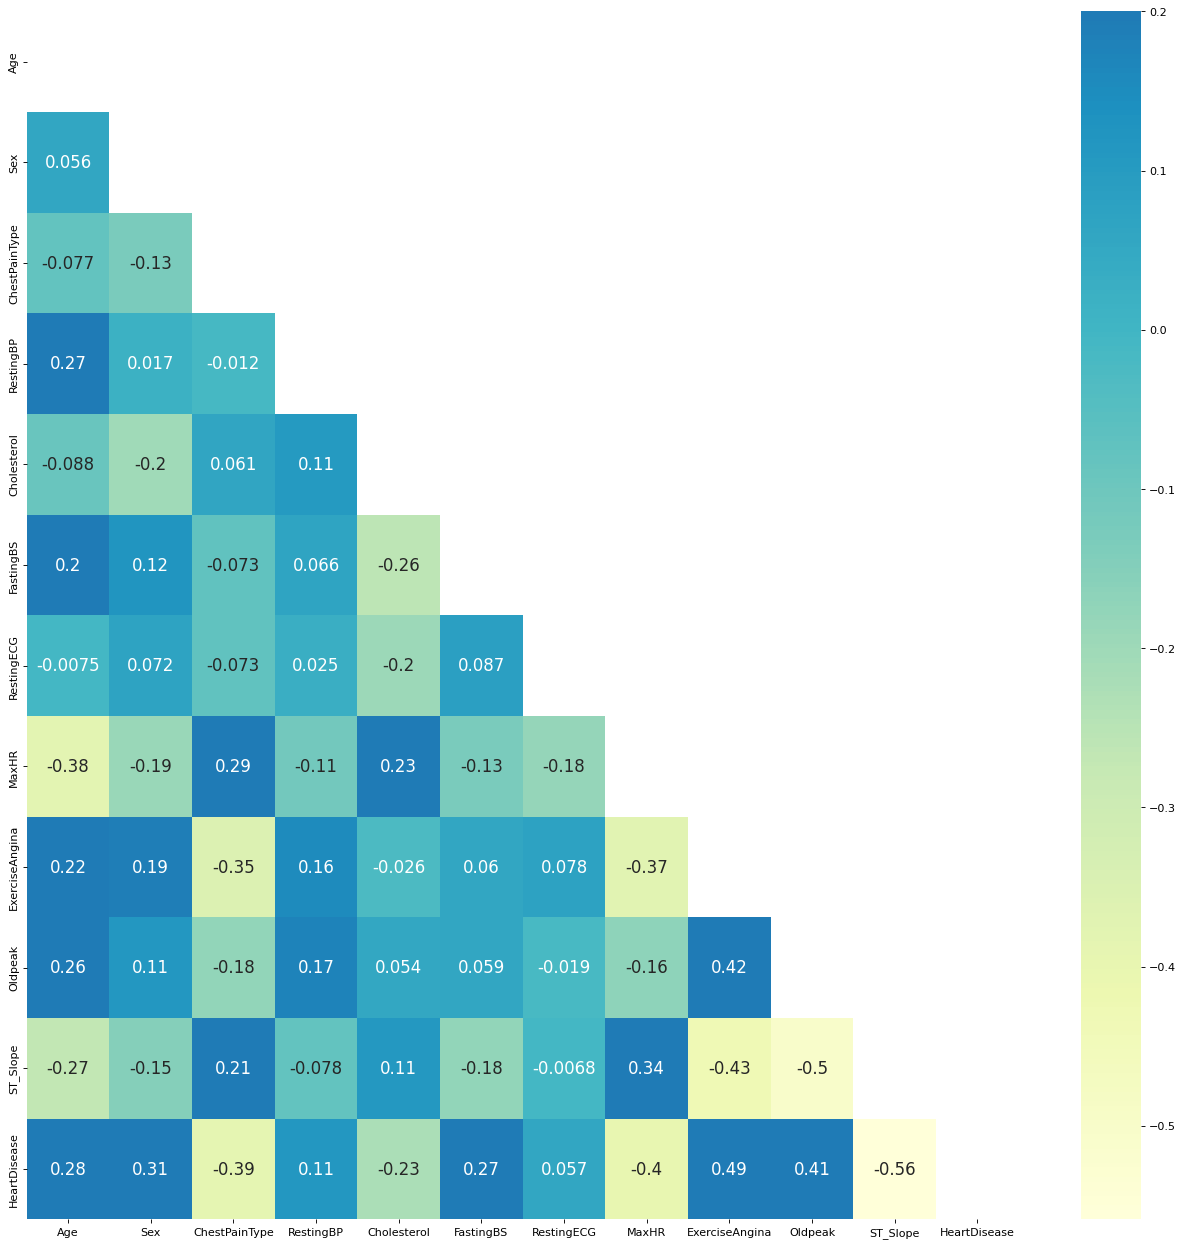

In [22]:
mask = np.triu(np.ones_like(df.corr()))
fig, ax = plt.subplots(figsize=(20,20),dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df.corr(), mask= mask, cmap="YlGnBu", vmax=.2, annot = True, center = 0,annot_kws={"fontsize":15})

# Train Test Split & Normalization

In [23]:
x = df.drop("HeartDisease", axis = 1)
y = df['HeartDisease']

In [1]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state =100 ,stratify=y, test_size = 0.3)
print(y_train.value_counts())

NameError: name 'train_test_split' is not defined

In [25]:
scale = MinMaxScaler()
col = ['Age', 'ChestPainType', 'RestingBP', 'Cholesterol',
       'RestingECG', 'MaxHR', 'Oldpeak', 'ST_Slope']

x_train[col] = scale.fit_transform(x_train[col])
x_test[col] = scale.transform(x_test[col])

# Feature Selction

In [26]:
sfs = SFS(GradientBoostingClassifier(n_estimators=100, random_state=0),
          k_features = 7,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 4,
          n_jobs= -1).fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.7s finished

[2021-12-18 11:09:19] Features: 1/7 -- score: 0.8130628881987577[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished

[2021-12-18 11:09:20] Features: 2/7 -- score: 0.8364615683229814[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.3s finished

[2021-12-18 11:09:22] Features: 3/7 -- score: 0.8457880434782609[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.2s finished

[2021-12-18 11:09:23] Features: 4/7 -- score: 0.861354

In [27]:
print("Best features: ",sfs.k_feature_names_)
print("Best score: ",sfs.k_score_)

Best features:  ('Sex', 'Cholesterol', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'Oldpeak', 'ST_Slope')
Best score:  0.8738451086956522


In [28]:
x_train_new = x_train[['Sex','Cholesterol','FastingBS','RestingECG','ExerciseAngina','Oldpeak','ST_Slope']]
x_test_new = x_test[['Sex','Cholesterol','FastingBS','RestingECG','ExerciseAngina','Oldpeak','ST_Slope']]

# Modeling with tuned hyperparameters 
> We used Grid search and Random search for tuning hyperparameters

### `Decision Tree Classifier`

In [29]:
DT = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=0)
DT.fit(x_train_new, y_train)

y_test_pred_DT = DT.predict(x_test_new)
y_train_pred_DT = DT.predict(x_train_new)

test_acc_DT = accuracy_score(y_test, y_test_pred_DT)
train_acc_DT = accuracy_score(y_train, y_train_pred_DT)
scores_DT = cross_val_score(DT, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_DT = precision_score(y_test, y_test_pred_DT)
recall_score_DT = recall_score(y_test, y_test_pred_DT)
f1_score_DT = f1_score(y_test, y_test_pred_DT)
conf_DT = confusion_matrix(y_test, y_test_pred_DT)


print("Tain set Accuracy: ", train_acc_DT)
print("Test set Accuracy: ", test_acc_DT)
print("cv:  %s\n"% scores_DT.mean())
print("************************************************")
print("precision_score: ", precision_score_DT)
print("recall_score: ", recall_score_DT)
print("f1_score: ", f1_score_DT)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_DT))

Tain set Accuracy:  0.8956386292834891
Test set Accuracy:  0.8297101449275363
cv:  0.8738461538461539

************************************************
precision_score:  0.8581081081081081
recall_score:  0.8300653594771242
f1_score:  0.8438538205980067
************************************************

Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       123
           1       0.86      0.83      0.84       153

    accuracy                           0.83       276
   macro avg       0.83      0.83      0.83       276
weighted avg       0.83      0.83      0.83       276




### `Random Forest Classifier`

In [30]:
RF = RandomForestClassifier(criterion='entropy', min_samples_leaf=2, n_estimators=25,
                       random_state=0)

RF.fit(x_train_new, y_train)

y_test_pred_RF = RF.predict(x_test_new)
y_train_pred_RF = RF.predict(x_train_new)

test_acc_RF = accuracy_score(y_test, y_test_pred_RF)
train_acc_RF = accuracy_score(y_train, y_train_pred_RF)
scores_RF= cross_val_score(RF, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_RF = precision_score(y_test, y_test_pred_RF)
recall_score_RF = recall_score(y_test, y_test_pred_RF)
f1_score_RF = f1_score(y_test, y_test_pred_RF)
conf_RF = confusion_matrix(y_test, y_test_pred_RF)


print("Tain set Accuracy: ", train_acc_RF)
print("Test set Accuracy: ", test_acc_RF)
print("cv:  %s\n"% scores_RF.mean())
print("************************************************")
print("precision_score: ", precision_score_RF)
print("recall_score: ", recall_score_RF)
print("f1_score: ", f1_score_RF)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_RF))


Tain set Accuracy:  0.926791277258567
Test set Accuracy:  0.8586956521739131
cv:  0.8645673076923078

************************************************
precision_score:  0.875
recall_score:  0.869281045751634
f1_score:  0.8721311475409835
************************************************

Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       123
           1       0.88      0.87      0.87       153

    accuracy                           0.86       276
   macro avg       0.86      0.86      0.86       276
weighted avg       0.86      0.86      0.86       276




### `MLPClassifier`

In [31]:
MLP = MLPClassifier(hidden_layer_sizes=10, learning_rate_init=0.1, random_state=0,
              solver='sgd')
MLP.fit(x_train_new, y_train)

y_test_pred_MLP = MLP.predict(x_test_new)
y_train_pred_MLP = MLP.predict(x_train_new)

test_acc_MLP = accuracy_score(y_test, y_test_pred_MLP)
train_acc_MLP = accuracy_score(y_train, y_train_pred_MLP)
scores_MLP = cross_val_score(MLP, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_MLP = precision_score(y_test, y_test_pred_MLP)
recall_score_MLP = recall_score(y_test, y_test_pred_MLP)
f1_score_MLP = f1_score(y_test, y_test_pred_MLP)
conf_MLP = confusion_matrix(y_test, y_test_pred_MLP)


print("Tain set Accuracy: ", train_acc_MLP)
print("Test set Accuracy: ", test_acc_MLP)
print("cv:  %s\n"% scores_MLP.mean())
print("************************************************")
print("precision_score: ", precision_score_MLP)
print("recall_score: ", recall_score_MLP)
print("f1_score: ", f1_score_MLP)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_MLP))

Tain set Accuracy:  0.8847352024922118
Test set Accuracy:  0.8478260869565217
cv:  0.8645432692307693

************************************************
precision_score:  0.8580645161290322
recall_score:  0.869281045751634
f1_score:  0.8636363636363638
************************************************

Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       123
           1       0.86      0.87      0.86       153

    accuracy                           0.85       276
   macro avg       0.85      0.85      0.85       276
weighted avg       0.85      0.85      0.85       276




### `Support Vector Classifier`

In [1]:
SVM = SVC(C=10, gamma=0.5, kernel='poly', random_state=0, probability=True)
SVM.fit(x_train_new, y_train)

y_test_pred_SVM = SVM.predict(x_test_new)
y_train_pred_SVM = SVM.predict(x_train_new)

test_acc_SVM = accuracy_score(y_test, y_test_pred_SVM)
train_acc_SVM = accuracy_score(y_train, y_train_pred_SVM)
scores_SVM = cross_val_score(SVM, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_SVM = precision_score(y_test, y_test_pred_SVM, average='macro')
recall_score_SVM = recall_score(y_test, y_test_pred_SVM, average='macro')
f1_score_SVM = f1_score(y_test, y_test_pred_SVM, average='macro')
conf_SVM = confusion_matrix(y_test, y_test_pred_SVM)


print("Tain set Accuracy: ", train_acc_SVM)
print("Test set Accuracy: ", test_acc_SVM)
print("cv:  %s\n"% scores_SVM.mean())
print("************************************************")
print("precision_score: ", precision_score_SVM)
print("recall_score: ", recall_score_SVM)
print("f1_score: ", f1_score_SVM)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_SVM))

NameError: name 'SVC' is not defined

### `Extra Trees Classifier`

In [33]:
ET = ExtraTreesClassifier(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                     n_estimators=200, random_state=0)
ET.fit(x_train_new, y_train)

y_test_pred_ET = ET.predict(x_test_new)
y_train_pred_ET = ET.predict(x_train_new)

test_acc_ET = accuracy_score(y_test, y_test_pred_ET)
train_acc_ET = accuracy_score(y_train, y_train_pred_ET)
scores_ET = cross_val_score(ET, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_ET = precision_score(y_test, y_test_pred_ET)
recall_score_ET = recall_score(y_test, y_test_pred_ET)
f1_score_ET = f1_score(y_test, y_test_pred_ET)
conf_ET = confusion_matrix(y_test, y_test_pred_ET)


print("Tain set Accuracy: ", train_acc_ET)
print("Test set Accuracy: ", test_acc_ET)
print("cv:  %s\n"% scores_ET.mean())
print("************************************************")
print("precision_score: ", precision_score_ET)
print("recall_score: ", recall_score_ET)
print("f1_score: ", f1_score_ET)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_ET))

Tain set Accuracy:  0.8722741433021807
Test set Accuracy:  0.8405797101449275
cv:  0.8707932692307694

************************************************
precision_score:  0.8385093167701864
recall_score:  0.8823529411764706
f1_score:  0.8598726114649682
************************************************

Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.82       123
           1       0.84      0.88      0.86       153

    accuracy                           0.84       276
   macro avg       0.84      0.84      0.84       276
weighted avg       0.84      0.84      0.84       276




### `Gradient Boosting Classifier`

In [34]:
GB = GradientBoostingClassifier(criterion='mse', loss='exponential',
                           min_samples_leaf=4, min_samples_split=6,
                           n_estimators=25, random_state=0)
GB.fit(x_train_new, y_train)

y_test_pred_GB = GB.predict(x_test_new)
y_train_pred_GB = GB.predict(x_train_new)

test_acc_GB = accuracy_score(y_test, y_test_pred_GB)
train_acc_GB = accuracy_score(y_train, y_train_pred_GB)
scores_GB = cross_val_score(GB, x_train_new , y_train , cv = 10, scoring = 'accuracy' )


precision_score_GB = precision_score(y_test, y_test_pred_GB)
recall_score_GB = recall_score(y_test, y_test_pred_GB)
f1_score_GB = f1_score(y_test, y_test_pred_GB)
conf_GB = confusion_matrix(y_test, y_test_pred_GB)

print("Tain set Accuracy: ", train_acc_GB)
print("Test set Accuracy: ", test_acc_GB)
print("cv:  %s\n"% scores_GB.mean())
print("************************************************")
print("precision_score: ", precision_score_GB)
print("recall_score: ", recall_score_GB)
print("f1_score: ", f1_score_GB)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_GB))

Tain set Accuracy:  0.897196261682243
Test set Accuracy:  0.8333333333333334
cv:  0.8738701923076924

************************************************
precision_score:  0.8451612903225807
recall_score:  0.8562091503267973
f1_score:  0.8506493506493505
************************************************

Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       123
           1       0.85      0.86      0.85       153

    accuracy                           0.83       276
   macro avg       0.83      0.83      0.83       276
weighted avg       0.83      0.83      0.83       276




### `Logistic Regression`

In [35]:
LR = LogisticRegression(C=2, penalty='l1', random_state=0, solver='liblinear')
LR.fit(x_train_new, y_train)

y_test_pred_LR = LR.predict(x_test_new)
y_train_pred_LR = LR.predict(x_train_new)

test_acc_LR = accuracy_score(y_test, y_test_pred_LR)
train_acc_LR = accuracy_score(y_train, y_train_pred_LR)
scores_LR = cross_val_score(LR, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_LR = precision_score(y_test, y_test_pred_LR)
recall_score_LR = recall_score(y_test, y_test_pred_LR)
f1_score_LR = f1_score(y_test, y_test_pred_LR)
conf_LR = confusion_matrix(y_test, y_test_pred_LR)


print("Tain set Accuracy: ", train_acc_LR)
print("Test set Accuracy: ", test_acc_LR)
print("cv:  %s\n"% scores_LR.mean())
print("************************************************")
print("precision_score: ", precision_score_LR)
print("recall_score: ", recall_score_LR)
print("f1_score: ", f1_score_LR)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_LR))

Tain set Accuracy:  0.8504672897196262
Test set Accuracy:  0.8115942028985508
cv:  0.8520432692307693

************************************************
precision_score:  0.8435374149659864
recall_score:  0.8104575163398693
f1_score:  0.8266666666666667
************************************************

Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       123
           1       0.84      0.81      0.83       153

    accuracy                           0.81       276
   macro avg       0.81      0.81      0.81       276
weighted avg       0.81      0.81      0.81       276




### `KNeighbors Classifier`

Text(0.5, 1.0, 'Accuracy Scores for Values of k of k-Nearest-Neighbors')

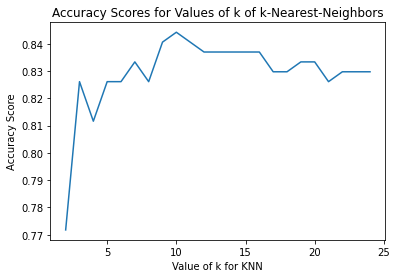

In [36]:
k_range = list(range(2,25))
scores = []

for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(x_train_new, y_train)
    y_pred = KNN.predict(x_test_new)
    scores.append(accuracy_score(y_test, y_pred))
    
plt.plot(k_range, scores)


plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')

plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')

In [37]:
d = {'best features number': range(2,25), 'train_score': scores}
df = pd.DataFrame(data=d)
print("max accuracy:",df["train_score"].max())
print("max accuracy id:",df["train_score"].idxmax())

max accuracy: 0.8442028985507246
max accuracy id: 8


In [38]:
KNN = KNeighborsClassifier(n_neighbors=8)
KNN.fit(x_train_new, y_train)

y_test_pred_KNN = KNN.predict(x_test_new)
y_train_pred_KNN = KNN.predict(x_train_new)

test_acc_KNN = accuracy_score(y_test, y_test_pred_KNN)
train_acc_KNN = accuracy_score(y_train, y_train_pred_KNN)
scores_KNN = cross_val_score(KNN, x_train_new , y_train , cv = 10, scoring = 'accuracy' )

precision_score_KNN = precision_score(y_test, y_test_pred_KNN)
recall_score_KNN = recall_score(y_test, y_test_pred_KNN)
f1_score_KNN = f1_score(y_test, y_test_pred_KNN)
conf_KNN = confusion_matrix(y_test, y_test_pred_KNN)

print("Tain set Accuracy: ", train_acc_KNN)
print("Test set Accuracy: ", test_acc_KNN)
print("cv:  %s\n"% scores_KNN.mean())
print("************************************************")
print("precision_score: ", precision_score_KNN)
print("recall_score: ", recall_score_KNN)
print("f1_score: ", f1_score_KNN)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_KNN))

Tain set Accuracy:  0.8753894080996885
Test set Accuracy:  0.8260869565217391
cv:  0.8505528846153846

************************************************
precision_score:  0.8523489932885906
recall_score:  0.8300653594771242
f1_score:  0.8410596026490067
************************************************

Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       123
           1       0.85      0.83      0.84       153

    accuracy                           0.83       276
   macro avg       0.82      0.83      0.82       276
weighted avg       0.83      0.83      0.83       276




### `Stacking Classifier`

In [39]:
estimators = [('DT', DT),
              ('RF', RF),
              ('SVM', SVM),
              ('MLP', MLP),
              ('ET', ET),
              ('LR', LR),
              ('KNN', KNN),
              ('GB', GB),
             ]

SC_tune_LR = StackingClassifier(estimators = estimators, final_estimator = LR)
SC_tune_LR.fit(x_train_new, y_train)

y_test_pred_SC_tune_LR = SC_tune_LR.predict(x_test_new)
y_train_pred_SC_tune_LR = SC_tune_LR.predict(x_train_new)

test_acc_SC_tune_LR = accuracy_score(y_test, y_test_pred_SC_tune_LR)
train_acc_SC_tune_LR = accuracy_score(y_train, y_train_pred_SC_tune_LR)
scores_SC_tune_LR = cross_val_score(SC_tune_LR, x_train_new , y_train , cv = 10, scoring = 'accuracy' )


precision_score_SC_tune_LR = precision_score(y_test, y_test_pred_SC_tune_LR)
recall_score_SC_tune_LR = recall_score(y_test, y_test_pred_SC_tune_LR)
f1_score_SC_tune_LR = f1_score(y_test, y_test_pred_SC_tune_LR)
conf_SC_tune_LR = confusion_matrix(y_test, y_test_pred_SC_tune_LR)

print("Tain set Accuracy: ", train_acc_SC_tune_LR)
print("Test set Accuracy: ", test_acc_SC_tune_LR)
print("cv:  %s\n"% scores_SC_tune_LR.mean())
print("************************************************")
print("precision_score: ", precision_score_SC_tune_LR)
print("recall_score: ", recall_score_SC_tune_LR)
print("f1_score: ", f1_score_SC_tune_LR)
print("************************************************")
print("\nReport:\n%s\n"%classification_report(y_test, y_test_pred_SC_tune_LR))

Tain set Accuracy:  0.897196261682243
Test set Accuracy:  0.8586956521739131
cv:  0.8692067307692308

************************************************
precision_score:  0.875
recall_score:  0.869281045751634
f1_score:  0.8721311475409835
************************************************

Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       123
           1       0.88      0.87      0.87       153

    accuracy                           0.86       276
   macro avg       0.86      0.86      0.86       276
weighted avg       0.86      0.86      0.86       276




# Compare Models

In [40]:
models = []
models.append(('DT', DT))
models.append(('RF', RF))
models.append(('MLP', MLP))
models.append(('SVM', SVM))
models.append(('ET', ET))
models.append(('LR', LR))
models.append(('KNN', KNN))
models.append(('GB', GB))
models.append(('SC', SC_tune_LR))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=100, shuffle=True)
    cv_results = cross_val_score(model, x_train_new, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    score = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(score)

DT: 0.870649 (0.047552)
RF: 0.873846 (0.039745)
MLP: 0.872188 (0.045361)
SVM: 0.869111 (0.043833)
ET: 0.867476 (0.050193)
LR: 0.837981 (0.045939)
KNN: 0.847332 (0.046726)
GB: 0.870625 (0.049088)
SC: 0.870625 (0.041546)


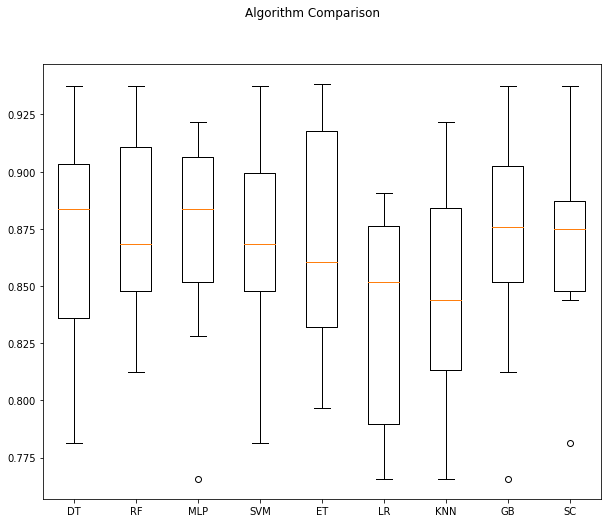

In [41]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [42]:
compare_models = [('Decision Tree', train_acc_DT, test_acc_DT, scores_DT.mean(), precision_score_DT, recall_score_DT, f1_score_DT, ''),
          ('Random Forest', train_acc_RF, test_acc_RF, scores_RF.mean(), precision_score_RF, recall_score_RF, f1_score_RF, ''),
          ('Neural Network', train_acc_MLP, test_acc_MLP, scores_MLP.mean(), precision_score_MLP, recall_score_MLP, f1_score_MLP,''),
          ('SVC', train_acc_SVM, test_acc_SVM, scores_SVM.mean(), precision_score_SVM, recall_score_SVM, f1_score_SVM,''),
          ('Extra Tree', train_acc_ET, test_acc_ET, scores_ET.mean(), precision_score_ET, recall_score_ET, f1_score_ET,''),
          ('GradientBoosting', train_acc_GB, test_acc_GB, scores_GB.mean(), precision_score_GB, recall_score_GB, f1_score_GB,''),
          ('Logistic Regression', train_acc_LR, test_acc_LR, scores_LR.mean(), precision_score_LR, recall_score_LR, f1_score_LR,''),
          ('KNN', train_acc_KNN, test_acc_KNN, scores_KNN.mean(), precision_score_KNN, recall_score_KNN, f1_score_KNN,''),
          ('Stacking', train_acc_SC_tune_LR, test_acc_SC_tune_LR, scores_SC_tune_LR.mean(), precision_score_SC_tune_LR, recall_score_SC_tune_LR, f1_score_SC_tune_LR,'The Best Model'),
         ]

In [43]:
predict = pd.DataFrame(data = compare_models, columns=['Model', 'Train_accuracy', 'Test_accuracy', 'CV_score','precision_score', 'recall_score', 'f1_score', 'Description'])
predict.style.background_gradient(cmap='YlGn')

,Model,Train_accuracy,Test_accuracy,CV_score,precision_score,recall_score,f1_score,Description
0,Decision Tree,0.895639,0.829710,0.873846,0.858108,0.830065,0.843854,
1,Random Forest,0.926791,0.858696,0.864567,0.875000,0.869281,0.872131,
2,Neural Network,0.884735,0.847826,0.864543,0.858065,0.869281,0.863636,
3,SVC,0.892523,0.847826,0.867668,0.845775,0.846804,0.846244,
4,Extra Tree,0.872274,0.840580,0.870793,0.838509,0.882353,0.859873,
5,GradientBoosting,0.897196,0.833333,0.873870,0.845161,0.856209,0.850649,
6,Logistic Regression,0.850467,0.811594,0.852043,0.843537,0.810458,0.826667,
7,KNN,0.875389,0.826087,0.850553,0.852349,0.830065,0.841060,
8,Stacking,0.897196,0.858696,0.869207,0.875000,0.869281,0.872131,The Best Model


# The best model --> Stacking
> The criterion for selecting the final model:
> Checking the difference between train and test accuracy (Checking the model in terms of overfitting) 

In [44]:
conf_matrix = confusion_matrix(y_test, y_test_pred_SC_tune_LR)

<AxesSubplot:>

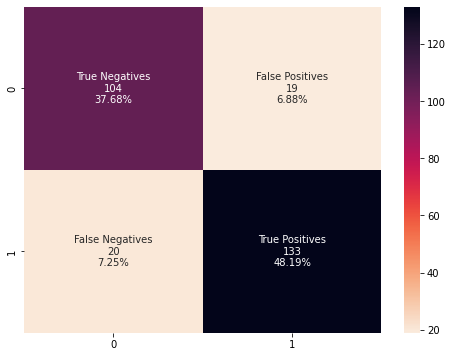

In [45]:
plt.figure(figsize=(8,6))
group_names = ['True Negatives', 'False Positives','False Negatives','True Positives']
group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt= '', cmap="rocket_r")

### **`confusion_matrix for cross_val_predict`**

In [46]:
y_pred_cross_val = cross_val_predict(SC_tune_LR, x_test_new, y_test, cv=10)
conf_matrix_cross_val = confusion_matrix(y_test, y_pred_cross_val)

<AxesSubplot:>

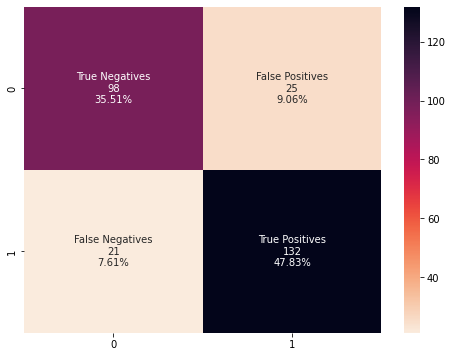

In [47]:
plt.figure(figsize=(8,6))
group_names = ['True Negatives', 'False Positives','False Negatives','True Positives']
group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix_cross_val.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix_cross_val.flatten()/np.sum(conf_matrix_cross_val)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix_cross_val, annot=labels, fmt= '', cmap="rocket_r")